# Assigment 2 

In this assigment we will work on a regression algorithm for predicting the stock price on a specific date.
We will use the TSLA stock price dataset from Yahoo Finance (Yahoo Finance, 2021).

# Imports

In [733]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Read data from csv


In [734]:
df = pd.read_csv("data/TSLA.csv")  # Read from file, (comma is the default)
df.head()  # Get an overview of the dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


## Find out what the types of the values are

In [735]:
# Check if we have any null values in our dataset
print(f"Any null values? {df.isnull().values.any()}")
df.info()  # Check the types for values

Any null values? False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845 entries, 0 to 2844
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2845 non-null   object 
 1   Open       2845 non-null   float64
 2   High       2845 non-null   float64
 3   Low        2845 non-null   float64
 4   Close      2845 non-null   float64
 5   Adj Close  2845 non-null   float64
 6   Volume     2845 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.7+ KB


We can see that the date column is not recognised, we need to convert it to the right type

## Clean and convert the data

In [736]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert from string to datetime
#df = df.set_index('Date')  # Set the date to be the index 
print(df.head())

        Date   Open   High    Low  Close  Adj Close    Volume
0 2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1 2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2 2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3 2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4 2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


## See correlations if any

<Axes: >

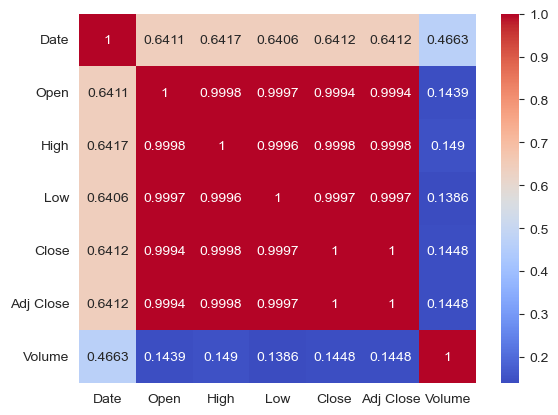

In [737]:
sns.heatmap(df.corr(), annot=True, fmt=".4g", cmap="coolwarm")  #Seaborn plot


We can see that Close and Adj Close is the same ^

In [738]:
df = df.drop(['Adj Close'], axis='columns')  # Drop the 'Adj Close' column

### Visualize the data

Text(0.5, 1.0, 'TSLA - Closing price')

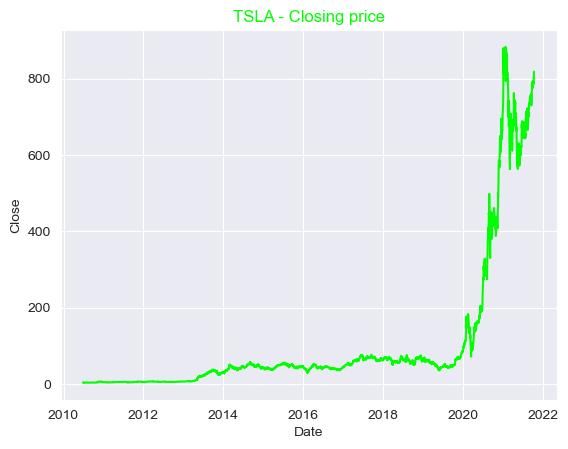

In [739]:
sns.lineplot(df, x='Date', y='Close', color='lime')
plt.title("TSLA - Closing price", color='lime')

Text(0.5, 1.0, 'TSLA - Volume')

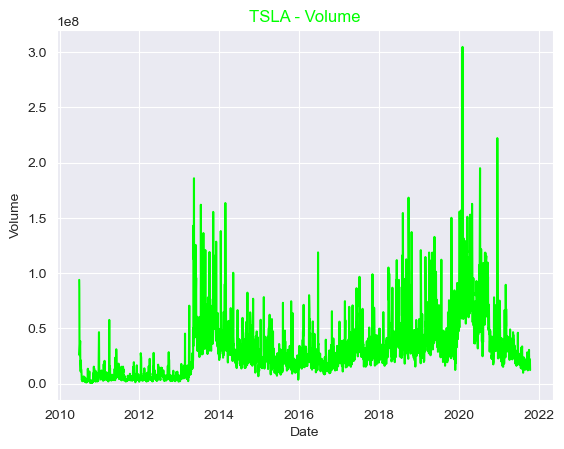

In [740]:
sns.lineplot(df, x='Date', y='Volume', color='lime')
plt.title("TSLA - Volume", color='lime')

### Check distribution using boxplots

Text(0.5, 1.0, 'TSLA - Distribution of closing price ')

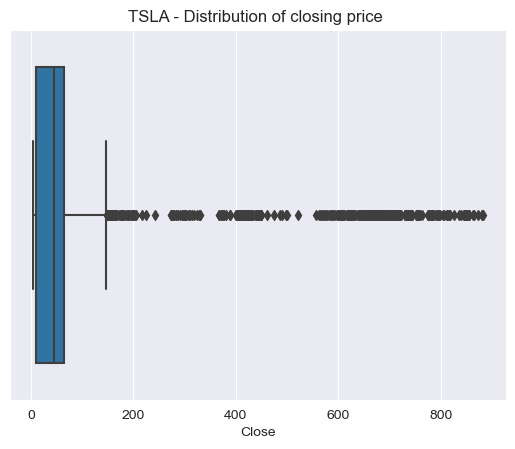

In [741]:
sns.boxplot(df, x='Close')
plt.title("TSLA - Distribution of closing price ")

We can observe outliers significantly distant from the upper quartiles, to fix this we can remove the outliers that fall outside the top 75 % and lower 25 % 

## Remove outliers

In [742]:
# Calculate the IQR for closing price
Q1 = df['Close'].quantile(0.25)  # Lower half
Q3 = df['Close'].quantile(0.75)  # Upper half
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows outside the bounds
df = df[(df['Close'] >= lower_bound) & (df['Close'] <= upper_bound)]

### Check distribution after removing outliers

Text(0.5, 1.0, 'TSLA - Distribution of closing price after removing outliers')

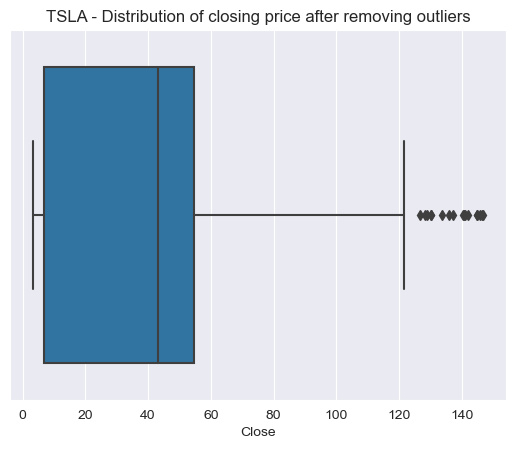

In [743]:
sns.boxplot(df, x='Close')
plt.title("TSLA - Distribution of closing price after removing outliers")

We can see now that the distribution is much better, we only have some outliers. 

### Visualize the data after removing outliers

Text(0.5, 1.0, 'TSLA - Closing price')

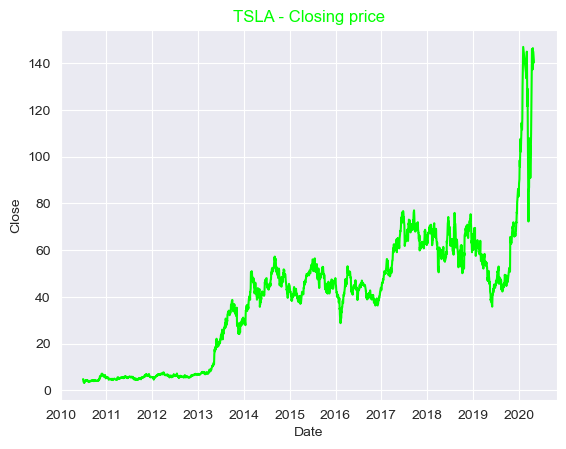

In [744]:
sns.lineplot(df, x='Date', y='Close', color='lime')
plt.title("TSLA - Closing price", color='lime')

Text(0.5, 1.0, 'TSLA - Volume')

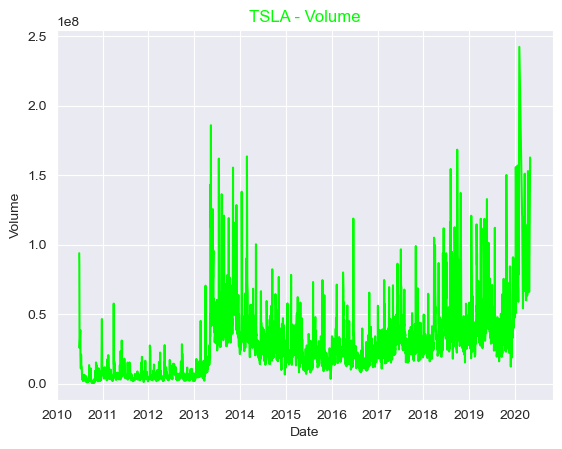

In [745]:
sns.lineplot(df, x='Date', y='Volume', color='lime')
plt.title("TSLA - Volume", color='lime')

## Train the model

### Splitting the training and testing set

In [746]:
X = pd.DataFrame(df['Date'])  #Date
y = pd.DataFrame(df['Close'])  #Close

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [747]:
### Save the model

In [748]:
test_degrees = 5  # Try different degrees of polynomial features
mse_degrees = []  # Create a list to store the MSE for each degree

# Loop through the degrees and fit the model, this is to find the best degree
for test_degrees in range(test_degrees):
    # Create polynomial features for the training and testing set
    polynomial_features = PolynomialFeatures(degree=test_degrees)  # Create polynomial features
    x_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training set
    x_poly_test = polynomial_features.fit_transform(X_test)  # Fit and transform the testing set

    # Train the model
    model = LinearRegression()  # Create a linear regression object
    model.fit(x_poly, y_train)  # Fit the model using the training set
    y_poly_pred = model.predict(x_poly_test)  # Predict the values for the testing set

    # Calculate the MSE on the testing set
    mse = metrics.mean_squared_error(y_test, y_poly_pred)
    mse_degrees.append((mse, test_degrees))  # Add the MSE and degree to the list 
    print(f"MSE = {mse} for degree = {test_degrees}")

# Sort the list of MSE to find the best degree
mse_degrees.sort()

# Get the best degree from the list
best_degree = mse_degrees[0][1]

print(f"Best degree {best_degree}")

# Train the model with the best degree we found again

# Create polynomial features for the training and testing set
polynomial_features = PolynomialFeatures(degree=best_degree)  # Create polynomial features
x_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training set
x_poly_test = polynomial_features.fit_transform(X_test)  # Fit and transform the testing set

# Train the model
model = LinearRegression()  # Create a linear regression object
model.fit(x_poly, y_train)  # Fit the model using the training set
y_poly_pred = model.predict(x_poly_test)  # Predict the values for the testing set

# Calculate the MSE on the testing set
mse = metrics.mean_squared_error(y_test, y_poly_pred)
print(f"MSE = {mse} for degree = {best_degree}")

MSE = 659.2823654251423 for degree = 0
MSE = 146.48873145759643 for degree = 1
MSE = 149.5704470678182 for degree = 2
MSE = 153.4087302492602 for degree = 3
MSE = 157.9516592051585 for degree = 4
Best degree 1
MSE = 146.48873145759643 for degree = 1


We can see that the MSE is quite high, this is because we are using a polynomial regression model on a time series dataset. We can see that the most fitting polynomial model is the model with only one degree ( a polynomial model with 1 degree means its linear and has no degrees. It would be better to use a time series model such as ARIMA or SARIMAX (Dhaduk, 2021). I have tried to implement these models but my knowledge of time series are limited at this point.

In [749]:
# Save the model and polynomial features to file
pickle.dump(model, open('model.sav', 'wb'))
pickle.dump(polynomial_features, open('poly.sav', 'wb'))

### Visualize the data

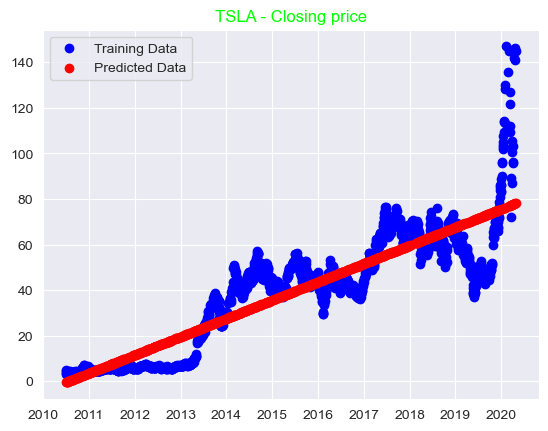

MSE = 146.48873145759643


In [750]:
plt.scatter(X_train, y_train, label='Training Data', color='blue')
plt.scatter(X_test, y_poly_pred, label='Predicted Data', color='red')
plt.title("TSLA - Closing price", color='lime')
plt.legend()
plt.show()

print("MSE = " + str(mse))